# Objective :
1. Convert reviews of "Amazon Fine Food Review" dataset into vectors using :-
    * Bag of words.
    * TF-IDF
    * Average Word2vec
    * TF-IDF Word2ves
2. Reduce dimensions of vectors using t-SNE.
3. Plot graph on reduced vectors.
 

In [40]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import re, gensim
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

## Importing data

In [41]:
"""
Reading data from .sqlite file,
choosing only positive and negative reviews not neutral reviews.
"""
# using the SQLite Table to read data.
con = sqlite3.connect('../input/database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative


## Cleansing data

In [42]:
"""
Below code snippet removes duplicate data from dataset that are repeatedly mentioned.
"""
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True,\
                                      inplace=False, kind='quicksort',\
                                      na_position='last')
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},\
                                  keep='first', inplace=False)
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

## Text preprocessing

In [43]:
"""
This code snippet does text preprocessing
"""
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
final_text = []
for index in range(len(final['Text'])):
    filtered_sentence=[]
    sent=cleanhtml(final['Text'].iloc[index]) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():# clean punctuation marks from words
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):# verifying word must be a alphabet and atleat two character long
                cleaned_words = cleaned_words.lower()
                if(cleaned_words not in stop):# blocks stopwords
                    s=(sno.stem(cleaned_words))# stemming in process
                    filtered_sentence.append(s)
                else:
                    continue
            else:
                continue 
    str1 = " ".join(filtered_sentence) #final cleaned string of words
    final_text.append(str1)

In [44]:
"""
THis code snippet is choosing 1500 positive and negative points
"""
positive_count =0
negative_count = 0
data_text=[]
data_label = []
for index in range(len(final['Score'])):
    if final['Score'].iloc[index] == 'positive' and positive_count < 1500:
        data_text.append(final_text[index])
        data_label.append(final['Score'].iloc[index])
        positive_count+=1
    elif final['Score'].iloc[index] == 'positive' and positive_count >= 1500:
        continue
    elif final['Score'].iloc[index] == 'negative' and negative_count < 1500:
        data_text.append(final_text[index])
        data_label.append(final['Score'].iloc[index])
        negative_count += 1
    else:
        break

In [45]:
amazon_data_text = pd.Series(data_text)
amazon_data_label = pd.Series(data_label)
print(amazon_data_text.shape)
print(amazon_data_label.shape)

(3000,)
(3000,)


### Bag of words.

In [46]:
"""
This code snippet converts text to vectors by BOW.
"""
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(amazon_data_text)
# # Data-preprocessing: Standardizing the data
# final_counts = StandardScaler().fit_transform(final_counts.toarray())
final_counts.shape

(3000, 8580)

In [49]:
"""
Dimension reduction through T-SNE for BOW
"""
model = TSNE(n_components=2, random_state=0, perplexity= 850, n_iter= 5000)
tsne_data = model.fit_transform(final_counts.toarray())
print("Shape of t-SNE_reduced data = ", tsne_data.shape)
# creating a new data frame which help us in ploting the result data
tsne_data1 = np.vstack((tsne_data.T, amazon_data_label)).T
tsne_df = pd.DataFrame(data=tsne_data1, columns=("Dim_1", "Dim_2", "label"))

Shape of t-SNE_reduced data =  (3000, 2)


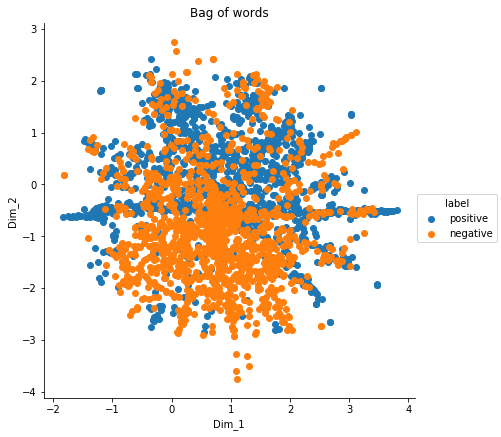

In [50]:
"""
Ploting the result of tsne
"""
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter,\
                                                'Dim_1', 'Dim_2').add_legend()
plt.title('Bag of words')
plt.show()

#### Observation :
* The model Bag of words is representation of text that describes occurence of words within it.
* It involves two things: A vocabulary of known words, a measure of the presence of known words(uni-grams).


### TF IDF.

In [53]:
"""
This code snippet converts text to vectors by TF_IDF.
"""
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(amazon_data_text)
final_tf_idf.get_shape()

(3000, 105115)

In [54]:
"""
Dimension reduction through T-SNE for TF_IDF
"""
tf_idf_model = TSNE(n_components=2, random_state=0, perplexity= 650, n_iter= 5000)
tsne_tf_idf_data = tf_idf_model.fit_transform(final_tf_idf.toarray())
print("Shape of t-SNE_reduced data = ", tsne_tf_idf_data.shape)
# creating a new data frame which help us in ploting the result data
tsne_tf_idf_data1 = np.vstack((tsne_tf_idf_data.T, amazon_data_label)).T
tsne_tf_idf_df = pd.DataFrame(data=tsne_tf_idf_data1, columns=("Dim_1", "Dim_2",\
                                                               "label"))

Shape of t-SNE_reduced data =  (3000, 2)


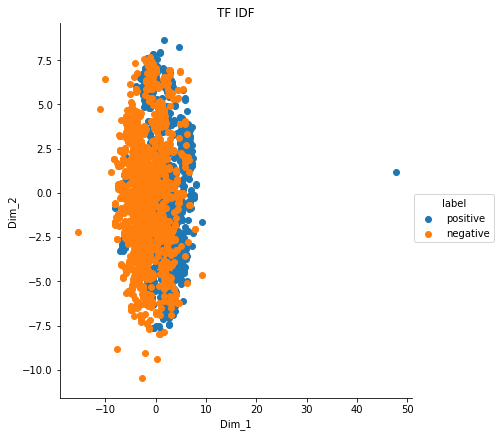

In [55]:
"""
Ploting the result of tsne
"""
sns.FacetGrid(tsne_tf_idf_df, hue="label", size=6).map(plt.scatter,\
                                                       'Dim_1','Dim_2').add_legend()
plt.title('TF IDF')
plt.show()

#### Observation:
* TF IDF is more advanced than Bag of words.
* It finds word's Term frequency amd Inverse document frequency and calculate it's weightage by their product.
* Unlike Bag of words it accepts multiple words(n-grams).
* End vectors have high dimensions compared to other algorithms.

## 3) Word2Vec

In [60]:
"""
Creating own vocabulary of words from reviews.
"""
i=0
list_of_sent=[]
for sent in amazon_data_text:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4) 

### a) Average Word2Vec

In [61]:
"""
This code snippet converts text to vectors by Average Word2Vec
"""
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

In [62]:
avg_w2v = np.asmatrix(sent_vectors)
avg_w2v.shape

(3000, 50)

In [69]:
"""
Dimension reduction through T-SNE for avg_word2vec
"""
avg_w2v_model = TSNE(n_components=2, random_state=0, perplexity= 650, n_iter= 5000)
tsne_avg_w2v_data = avg_w2v_model.fit_transform(avg_w2v)
print("Shape of t-SNE_reduced data = ", tsne_avg_w2v_data.shape)
# creating a new data frame which help us in ploting the result data
tsne_avg_w2v_data1 = np.vstack((tsne_avg_w2v_data.T, amazon_data_label)).T
tsne_avg_w2v_df = pd.DataFrame(data=tsne_avg_w2v_data1, columns=("Dim_1",\
                                                                 "Dim_2", "label"))

Shape of t-SNE_reduced data =  (3000, 2)


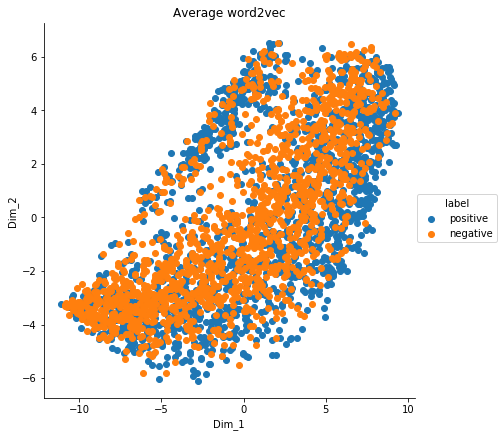

In [70]:
"""
Ploting the result of tsne
"""
sns.FacetGrid(tsne_avg_w2v_df, hue="label", size=6).map(plt.scatter,\
                                                        'Dim_1', 'Dim_2').add_legend()
plt.title('Average word2vec')
plt.show()

#### Observation:
* Unlike above two alogorithms it converts the whole sentence into vectors.
* It assumes all words have same weightage.
* The most important thing is that it take words semantics into consideraton.

### b) TF IDF Word2Vec

In [65]:
"""
This code snippet converts text to vectors by TF-IDF weighted Word2Vec
"""
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(amazon_data_text)
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [66]:
tf_idf_w2v = np.asmatrix(tfidf_sent_vectors)
tf_idf_w2v.shape

(3000, 50)

In [67]:
"""
Dimension reduction through T-SNE
"""
tf_idf_w2v_model = TSNE(n_components=2, random_state=0, perplexity= 800,n_iter= 5000)
tsne_tf_idf_w2v_data = tf_idf_w2v_model.fit_transform(tf_idf_w2v)
print("Shape of t-SNE_reduced data = ", tsne_tf_idf_w2v_data.shape)
# creating a new data frame which help us in ploting the result data
tsne_tf_idf_w2v_data1 = np.vstack((tsne_tf_idf_w2v_data.T, amazon_data_label)).T
tsne_tf_idf_w2v_df = pd.DataFrame(data=tsne_tf_idf_w2v_data1,columns=("Dim_1",\
                                                                       "Dim_2","label"))

Shape of t-SNE_reduced data =  (3000, 2)


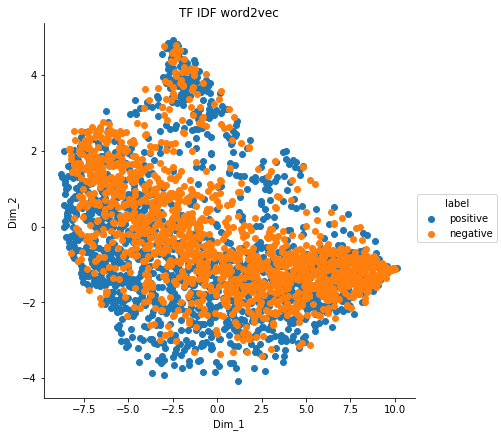

In [68]:
"""
Ploting the result of tsne
"""
sns.FacetGrid(tsne_tf_idf_w2v_df, hue="label", size=6).map(plt.scatter,'Dim_1',\
                                                           'Dim_2').add_legend()
plt.title('TF IDF word2vec')
plt.show()

#### Observation:
* It also converts the whole sentence into vectors and take words semantics into consideraton.
* Unlike avg. word2vec it calculate every word's weightage.

## Conclusion :
1. The last two algorithms(i.e. word2vec algorithms) are much better than BOW and TF IDF because they remove outliers or less appered words and thay keep words with same symantics together.
2. By reducing dimension with t-SNE with diffrent hyperparameters, I got the result that "TF IDF word2vec" have better performance than other three to separate positive and negative reviews.